# Compose materials from structures in CIF files and databases.

Beyond the simplest materials, most crystal structures are too complicated to enter manually. For that purpose, NCrystal v3.6 introduced support for reading crystal structures from other existing sources. This mostly means CIF files (https://www.iucr.org/resources/cif), but also from select online databases, or even a plethora of other input formats (e.g. Quantum Espresso files) through the impressive conversion capabilities of the ASE framework (https://wiki.fysik.dtu.dk/ase/).


## Preamble ##
Fix dependencies and tune jupyter a bit. Feel free to replace as you wish:

In [1]:
#Optionally install dependencies via pip. The default is to do this only
#on Google Colab, but you can modify the next line to do it always:
always_do_pip_installs = False # Set to True to enable outside Google Colab
import os
if always_do_pip_installs or os.environ.get("COLAB_RELEASE_TAG"):
    %pip -q install ncrystal ipympl numpy matplotlib spglib gemmi
    #NOTE: Also add "pymatgen" to the list, if you will be using materials from the Materials Project.

In [2]:
#enable inline matplotlib plots:
if os.environ.get("COLAB_RELEASE_TAG"):
  print("Google Colab detected, matplotlib plots will not be interactive")
  %matplotlib inline
  import matplotlib
  matplotlib.rcParams.update({"figure.autolayout": True})
else:
  print("Enabling interactive matplotlib plots (requires ipympl installed)")
  %matplotlib ipympl
  import matplotlib
  matplotlib.rcParams.update({"figure.figsize":(6.4*0.5,4.8*0.5),
                              "figure.dpi":150,
                              'font.size':5,
                              "figure.autolayout": True})

Enabling interactive matplotlib plots (requires ipympl installed)


In [3]:
%%html
<style>div.jupyter-widgets.widget-label {display: none;}</style>

Always import NCrystal of course:

In [4]:
import NCrystal as NC
assert NC.version_num >=  3009003
NC.test() #< quick unit test that installation works!

Tests completed succesfully


The following environment variable is not strictly necessary, but included here to prevent repeated downloads of the same files from online databases:

In [5]:
import os
os.environ['NCRYSTAL_ONLINEDB_CACHEDIR'] = './ncrystal_onlinedb_filecache'

## Basic CIF data support
Let us start by a simple case, where somehow we have gotten a piece of very simple CIF data already defined directly in our Python code:

In [6]:
dummy_cif_data="""
data_al
loop_
_space_group_IT_number           225
_symmetry_space_group_name_Hall  '-F 4 2 3'
_symmetry_space_group_name_H-M   'F m -3 m'
_cell_angle_alpha                90
_cell_angle_beta                 90
_cell_angle_gamma                90
_cell_length_a                   4.049
_cell_length_b                   4.049
_cell_length_c                   4.049
_cell_volume                     66.381
loop_
_atom_site_label
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
Al 0.00000 0.00000 0.00000
"""

The NCMATComposer can load this directly, and we can indeed recognise the aluminium structure that we have also used in previous examples:

In [7]:
c_cif_Al = NC.NCMATComposer(dummy_cif_data)
print(c_cif_Al())

Attempting to load CIF data with gemmi
Self-consistency of structure was verified by spglib
NCMAT v7
# Autogenerated by NCMATComposer
#
# Al (cubic, SG-225)
#
# Atoms per unit cell: 4xAl
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   Anonymous CIF data
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# WARNING: Fallback (dummy) Debye temperature value was used for 1 atom!
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  cubic 4.049
@SPACEGROUP
  225
@ATOMPOSITIONS
  Al 0 0 0
  Al 0 1/2 1/2
  Al 1/2 0 1/2
  Al 1/2 1/2 0
@DYNINFO
  # WARNING: Using fallback Debye temperature value!
  element Al
  fraction 1


## A real-world example: Bismuth from CIF

Or, here is a more complicated example, where we have found an entry in the online Crystallography Open Database by using the search functionality at https://www.crystallography.net/cod/. Specifically we have searched for Bismuth and found the entry https://www.crystallography.net/cod/7123352.html (the number 7123352 is the ID of the material in the database). Now, we could in principle use the web interface and download the .cif file manually, but NCrystal can do this automatically if you simply specify the entry in a string as `"codid::7123352"`:

In [8]:
c_cif_codBi_attempt1 = NC.NCMATComposer('codid::7123352')

Getting cod_7123352.cif from local file cache in $NCRYSTAL_ONLINEDB_CACHEDIR
Attempting to load CIF data with gemmi
Self-consistency of structure was verified by spglib


/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:1486: NCrystalUserWarning: SG-166 available in multiple choices ("R -3 m:H", "R -3 m:R") and which one was not encoded explicitly in the _space_group_name_H-M_alt CIF field. Consider overriding the space group explicitly when loading this file.
  _nc_common.warn(f'SG-{sg.number} available in multiple choices ("{_str}") and'
/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:1563: NCrystalUserWarning: Fractional coordinate (0.666667,0.333333,0.56724) interpreted as special position (0.666666666666667,0.333333333333333,0.56724) to avoid numerical precision issues
  _nc_common.warn('Fractional coordinate %s interpreted as special position %s to avoid numerical precision issues'%(fmt(coord),fmt(pos0_new)))
/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:868: NCrystalUserWarning: ignoring uiso info present in CIF input for "Bi" since uiso_temperature parameter value is not provided

  _nc_c

In [9]:
print(c_cif_codBi_attempt1())

NCMAT v7
# Autogenerated by NCMATComposer
#
# Bi (trigonal, SG-166)
#
# Atoms per unit cell: 6xBi
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   "From a volatile molecular precursor to twin-free single crystals of
#    bismuth"
#   Wei, Zheng, et al. [Chemical Communications, 2019]
#   DOI: https://dx.doi.org/10.1039/C9CC02820J
#   CIF creation method: SHELXL-2018/3
#   Crystallography Open Database entry 7123352
#   https://www.crystallography.net/cod/7123352.html
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# Notice: The following WARNINGS were emitted when loading the CIF data:
#
#   NCrystalUserWarning : SG-166 available in multiple cho

As you can tell, this seemed to work, but there were several warnings emitted along the way (be sure to scroll to the bottom of the previous output cell if you missed them). For reference, these warnings are also captured and repeated inside the NCMAT data. We can look at the warnings one at a time, however not exactly in the order they were emitted.

The warning `"Fractional coordinate (0.666667,0.333333,0.56724) interpreted as special position (0.666666666666667,0.333333333333333,0.56724) to avoid numerical precision issues"`: Basically, the precision in the input data was too low, and NCrystal detected this and corrected for it. That looks fine and nothing to worry about.

The warning `"ignoring uiso info present in CIF input for "Bi" since uiso_temperature parameter value is not provided"` is emitted since the CIF data actually DID contain information about atomic displacements, but NCrystal also needs to know the temperature value for which these atomic displacements were measured (or modelled or whatever). To figure that out, we will have to try to inspect the raw CIF data and see if we can find a clue - either directly in the data itself or by pursuing the references given therein. We will get back to that.

The warning `"Anisotropic displacement for Bi ignored (u11=0.01993, u12=0.00996, u13=0, u22=0.01993, u23=0, u33=0.01684)"` means that not only did the CIF file contain atomic displacement info, it even contained *anisotropic* displacement info. Using these is currently not supported by NCrystal, and in practice their effect is likely negligible for most applications. Thus, this warning is just there as a notification, there is nothing to be done about it.

Finally, the warning `"SG-166 available in multiple choices ("R -3 m:H", "R -3 m:R") and which one was not encoded explicitly in the _space_group_name_H-M_alt CIF field. Consider overriding the space group explicitly when loading this file."` is because the space group symmetry could not be determined unambiguously from the file. This happens often, since many of the 230 space groups have more than one "setting, as we can see in the following list:

In [10]:
import gemmi
for num,xhm in sorted((t.number,t.xhm()) for t in gemmi.spacegroup_table()):
    print(f'SG-{str(num).ljust(6)}: "{xhm}"')


SG-1     : "A 1"
SG-1     : "B 1"
SG-1     : "C 1"
SG-1     : "F 1"
SG-1     : "I 1"
SG-1     : "P 1"
SG-2     : "A -1"
SG-2     : "B -1"
SG-2     : "C -1"
SG-2     : "F -1"
SG-2     : "I -1"
SG-2     : "P -1"
SG-3     : "B 1 2 1"
SG-3     : "C 1 1 2"
SG-3     : "P 1 1 2"
SG-3     : "P 1 2 1"
SG-3     : "P 2 1 1"
SG-4     : "B 1 21 1"
SG-4     : "C 1 1 21"
SG-4     : "P 1 1 21"
SG-4     : "P 1 21 1"
SG-4     : "P 21 1 1"
SG-5     : "A 1 1 2"
SG-5     : "A 1 2 1"
SG-5     : "B 1 1 2"
SG-5     : "B 2 1 1"
SG-5     : "C 1 2 1"
SG-5     : "C 1 21 1"
SG-5     : "C 2 1 1"
SG-5     : "F 1 2 1"
SG-5     : "I 1 1 2"
SG-5     : "I 1 2 1"
SG-5     : "I 1 21 1"
SG-5     : "I 2 1 1"
SG-6     : "P 1 1 m"
SG-6     : "P 1 m 1"
SG-6     : "P m 1 1"
SG-7     : "P 1 1 a"
SG-7     : "P 1 1 b"
SG-7     : "P 1 1 n"
SG-7     : "P 1 a 1"
SG-7     : "P 1 c 1"
SG-7     : "P 1 n 1"
SG-7     : "P b 1 1"
SG-7     : "P c 1 1"
SG-7     : "P n 1 1"
SG-8     : "A 1 1 m"
SG-8     : "A 1 m 1"
SG-8     : "B 1 1 m"
SG-8  

Let us address these issues one by one. First of all, we can inspect the raw CIF data, as well as consult the reference paper at https://dx.doi.org/10.1039/C9CC02820J (paywall) which is mentioned in the raw CIF data, and this mention which was also transferred automatically into the generated NCMAT data above. The paper is behind a paywall, but reading it one discovers that they considered two temperatures, 100K and 298K. Now, let us look at the raw CIF data. This is most easily done by using the `CIFSource` object from the `NCrystal.cifutils` module:

In [11]:
import NCrystal.cifutils as nccif
cifsrc = nccif.CIFSource('codid::7123352')
print( cifsrc.load_data() )

Getting cod_7123352.cif from local file cache in $NCRYSTAL_ONLINEDB_CACHEDIR
#------------------------------------------------------------------------------
#$Date: 2019-05-01 01:12:56 +0300 (Wed, 01 May 2019) $
#$Revision: 214853 $
#$URL: file:///home/coder/svn-repositories/cod/cif/7/12/33/7123352.cif $
#------------------------------------------------------------------------------
#
# This file is available in the Crystallography Open Database (COD),
# http://www.crystallography.net/
#
# All data on this site have been placed in the public domain by the
# contributors.
#
data_7123352
loop_
_publ_author_name
'Wei, Zheng'
'Dubceac, Cristina'
'Petrukhina, Marina A.'
'Dikarev, Evgeny V.'
_publ_section_title
;
 From a volatile molecular precursor to twin-free single crystals of
 bismuth
;
_journal_name_full               'Chemical Communications'
_journal_paper_doi               10.1039/C9CC02820J
_journal_year                    2019
_chemical_formula_moiety         Bi
_chemical_formula_

In case you missed it above, we found a single mention of temperature in the line: 
```
_cod_data_source_block           300K
```
Which is very close to one of the two values (100K and 298K) we found in the paper. So we will for simplicity assume the atomic displacements in the file, are valid at 299K.

Concerning which of the spacegroups to use, `"R -3 m:H"` or `"R -3 m:R"`, we will have to simply see the effect. Let us try to create the materials again. Since we need to pass along a few more parameters, we will use the `NCMATComposer.from_cif(..)` method, rather than the constructor `NCMATComposer(..)`:

In [12]:
c_choice1 = NC.NCMATComposer.from_cif('codid::7123352', uiso_temperature=299, override_spacegroup="R -3 m:H")

Getting cod_7123352.cif from local file cache in $NCRYSTAL_ONLINEDB_CACHEDIR
Attempting to load CIF data with gemmi
Self-consistency of structure was verified by spglib


/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:1462: NCrystalUserWarning: Overriding spacegroup to "R -3 m:H" due to explicit request
  _nc_common.warn(f'Overriding spacegroup to "{override_spacegroup}" due to explicit request')
/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:1563: NCrystalUserWarning: Fractional coordinate (0.666667,0.333333,0.56724) interpreted as special position (0.666666666666667,0.333333333333333,0.56724) to avoid numerical precision issues
  _nc_common.warn('Fractional coordinate %s interpreted as special position %s to avoid numerical precision issues'%(fmt(coord),fmt(pos0_new)))
/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:874: NCrystalUserWarning: Anisotropic displacement for Bi ignored (u11=0.01993, u12=0.00996, u13=0, u22=0.01993, u23=0, u33=0.01684)
  _nc_common.warn('Anisotropic displacement for %s ignored (%s)'%(composstr,', '.join (f'{k}={v:g}' for k,v in sorted(_aniso.items()))))


In [13]:
#This second one is possibly going to fail, so enclosing in try/except to not break the entire notebook:
try:
    c_choice2 = NC.NCMATComposer.from_cif('codid::7123352', uiso_temperature=299, override_spacegroup="R -3 m:R")
except NC.NCBadInput as e:
    c_choice2 = None
    print(f'ERROR NCBadInput: {e}')

Getting cod_7123352.cif from local file cache in $NCRYSTAL_ONLINEDB_CACHEDIR
Attempting to load CIF data with gemmi
Self-consistency of structure was verified by spglib


/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:1462: NCrystalUserWarning: Overriding spacegroup to "R -3 m:R" due to explicit request
  _nc_common.warn(f'Overriding spacegroup to "{override_spacegroup}" due to explicit request')
/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:1563: NCrystalUserWarning: Fractional coordinate (0.666667,0.333333,0.56724) interpreted as special position (0.666666666666667,0.333333333333333,0.56724) to avoid numerical precision issues
  _nc_common.warn('Fractional coordinate %s interpreted as special position %s to avoid numerical precision issues'%(fmt(coord),fmt(pos0_new)))
/some/where/venv/lib/python3.12/site-packages/NCrystal/cifutils.py:874: NCrystalUserWarning: Anisotropic displacement for Bi ignored (u11=0.01993, u12=0.00996, u13=0, u22=0.01993, u23=0, u33=0.01684)
  _nc_common.warn('Anisotropic displacement for %s ignored (%s)'%(composstr,', '.join (f'{k}={v:g}' for k,v in sorted(_aniso.items()))))


Depending on gemmi and spglib libraries, it might be that `c_choice2` was not created, or it might be that it indeed was! If it was, we better check that there are no differences between `c_choice1` and `c_choice2` (so there should either be NO plot, or there should be a plot with two identical curves):

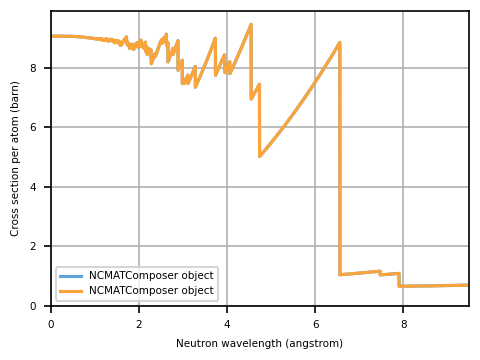

In [14]:
if c_choice2 is not None:
    import NCrystal.plot as ncplot
    ncplot.plot_xsects(c_choice1,c_choice2)

Whether or not two second of the two possible spacegroup settings turned out to be incompatible with the unit cell parameters defined in the same CIF file, or whether or not it turned out to give an identical result, it in any case means that we can use the first choice, `"R -3 m:H"`. Let us (for convenience) give the new material a virtual name, and inspect the beautiful NCMAT data we have thus created:

In [15]:
c_choice1.register_as('newBi.ncmat')
print(c_choice1())

NCMAT v7
# Autogenerated by NCMATComposer
#
# Bi (trigonal, SG-166)
#
# Atoms per unit cell: 6xBi
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   "From a volatile molecular precursor to twin-free single crystals of
#    bismuth"
#   Wei, Zheng, et al. [Chemical Communications, 2019]
#   DOI: https://dx.doi.org/10.1039/C9CC02820J
#   CIF creation method: SHELXL-2018/3
#   Crystallography Open Database entry 7123352
#   https://www.crystallography.net/cod/7123352.html
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# Notice: The following WARNINGS were emitted when loading the CIF data:
#
#   NCrystalUserWarning : Overriding spacegroup to "R -3 m

We can compare that with the Bismuth already in NCrystal:

In [16]:
print(NC.createTextData("stdlib::Bi_sg166.ncmat").rawData)

NCMAT v5
#
# Bismuth (Bi, trigonal, SG-166 / R-3m)
#
# Under usual conditions this phase exists from 0 to 500K.
#
# Structure converted with ncrystal_onlinedb2ncmat from:
#
#    "The crystal structure of Bi and of solid solutions
#     of Pb, Sn, Sb and Te in Bi"
#    Cucka, P. and Barrett, C.S.
#    Acta Cryst. (1962). 15, 865-872
#    DOI: https://doi.org/10.1107/S0365110X62002297
#    Crystallography Open Database entry 2310889
#    https://www.crystallography.net/cod/2310889.html
#
# This crystal structure is also compatible with structures obtained from:
#
#    https://www.crystallography.net/cod/5000215.html
#    https://www.crystallography.net/cod/7123351.html
#    https://www.crystallography.net/cod/7123352.html
#    https://www.crystallography.net/cod/9008576.html
#
# Note that while https://www.materialsproject.org/ seems to contain many
# Bismuth structures, they are mutually incompatible and none seem to be
# compatible with the crystal structure here.
#
# Reference for VDO

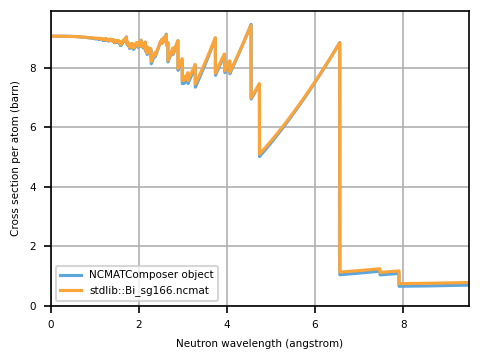

In [17]:
import NCrystal.plot as ncplot
ncplot.plot_xsects(c_choice1,"stdlib::Bi_sg166.ncmat")

Indeed the results look very similar, except for the fact that the stdlib file contains a full VDOS rather than just a simplified one:

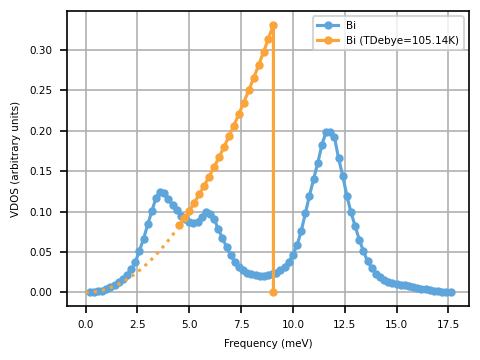

In [18]:
info_std = NC.createInfo("stdlib::Bi_sg166.ncmat")
di_std = info_std.dyninfos[0]
info_new = c_choice1.load().info
di_new = info_new.dyninfos[0]
ncplot.plot_vdos(di_std,di_new)

For fun, we can compare the atomic displacements predicted by the two VDOS curves:

In [19]:
print( di_new.correspondingAtomInfo().msd )
print( di_std.correspondingAtomInfo().msd )

0.018532619088126995
0.021905425309079275


Pretty close, all things considered!! So we can be pretty happy with our new NCMAT data for Bismuth. A possible improvement would of course be to add a phonon DOS curve for it, which we will get back to in another notebook.

But one question might bother you: How would I verify that I loaded the right crystal structure if I did not have a "stdlib::Bi_sg166.ncmat" to compare with. Well, first of all you could have looked at the structure in the resulting material and tried to read about the structure in the references (or in online search results), and perhaps you would have been satisfied. Barring an experimental campaign at a powder diffractometer, there is one other approach which fortunately is possible for most materials: Find not just 1, but many, entries for the material in online databases, and see how they compare after loading. Perhaps load each of them like above, and finally use `NCrystal.plot.plot_xsects` to check that the Bragg edges all line up. But there is one other quick-and-dirty way, which is to ask NCrystal to compare the crystal structure in a given NCMAT file, with any online database entries references in the comments of that NCMAT file. For instance, we saw above that `"stdlib::Bi_sg166.ncmat"` contained a total of 5 such mentions of COD entries, and we can easily check them like this:

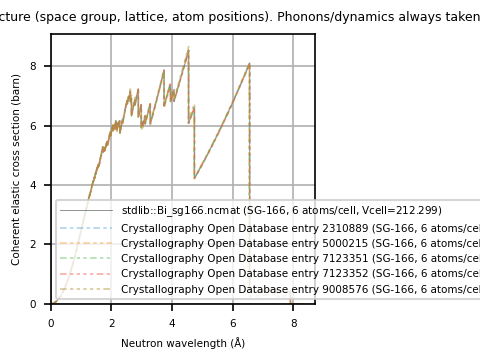

In [20]:
import NCrystal.cifutils as nccif
nccif.produce_validation_plot('stdlib::Bi_sg166.ncmat',line_width_scale=0.2,quiet=True)

Looks pretty good! For reference, we can of course also make such a plot without having to edit the comments of a CIF file. For instance after searching COD for relevant Bismuth structures, you can write the following code:

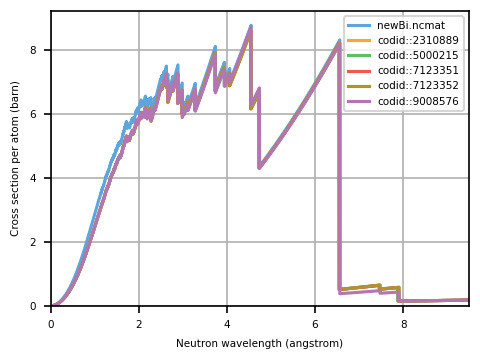

In [21]:
import NCrystal.plot
bismuth_srcs = ['newBi.ncmat']
for codid in [2310889,5000215,7123351,7123352,9008576]:
    c=NC.NCMATComposer(f'codid::{codid}',plotlabel=f'codid::{codid}',quiet=True)
    c.transfer_dyninfo_objects('stdlib::Bi_sg166.ncmat')
    bismuth_srcs.append( c )
NC.plot.plot_xsects(*bismuth_srcs,extra_cfg='comp=bragg')

## Site occupancy factors
Many real-world crystals have a defect where some sites are not 100% occupied. Accordingly, many CIF files contain so-called "site occupancy factors", with values less than 1.0. The python layer of NCrystal (including the `NCMATComposer` and `CIFLoader`) supports these, but currently (NCrystal v3.6) the support has not made it into the underlying C++ backend yet. So for now, the solution is that the `NCMATComposer` carefully uses the support for overriding atomic data to insert a bit of "dark matter" into the crystal, with the right masses and mixtures of course. Let us see a silly fabricated example:

In [22]:
cif_data_with_siteoccu = """data_DUMMY
_cell_length_a 4.0
_cell_length_b 4.0
_cell_length_c 4.0
_cell_angle_alpha 90.0
_cell_angle_beta  90.0
_cell_angle_gamma 90.0
_space_group_name_H-M_alt 'P m -3 m'
loop_
_atom_site_label
_atom_site_type_symbol
_atom_site_occupancy
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
C  C  0.88 0.0 0.0 0.0
Al Al 1.00 0.5 0.5 0.5
"""

If we load it, we get (scroll down and observe the hack in the `@ATOMDB` section):

In [23]:
c_siteoccu = NC.NCMATComposer.from_cif(cif_data_with_siteoccu)
print( c_siteoccu() )

Attempting to load CIF data with gemmi
Self-consistency of structure was verified by spglib
NCMAT v7
# Autogenerated by NCMATComposer
#
# C22Al25 (cubic, SG-221)
#
# Atoms per unit cell: 1xAl+0.88xC
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   Anonymous CIF data
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# Notice: The following WARNINGS were emitted when loading the CIF data:
#
#   NCrystalUserWarning : Support for site_occupancy is highly experimental. Do *not* attempt to directly override value with the "density" cfg-parameter for this material (unless it is to simply scale it)
#
# WARNING: Fallback (dummy) Debye temperature values we

/some/where/venv/lib/python3.12/site-packages/NCrystal/_ncmatimpl.py:651: NCrystalUserWarning: Support for site_occupancy is highly experimental. Do *not* attempt to directly override value with the "density" cfg-parameter for this material (unless it is to simply scale it)
  _nc_common.warn('Support for site_occupancy is highly experimental. Do *not* attempt to directly override'


The material works:

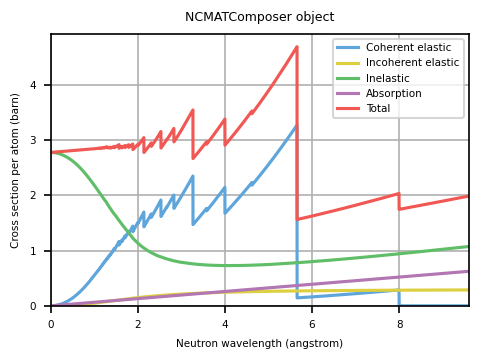

In [24]:
c_siteoccu.plot_xsect()

The only problem is that asking about composition, density, or cross-section-per-atom will give misleading results. However, the results cancel out, so the cross-section-per-volume is correct!

[(0.5,
  Al=Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815amu Z=13)),
 (0.5,
  Mix=Mix{88%C+12%Og299}(cohSL=5.84848fm cohXS=4.29829barn incXS=0.587011barn absXS=0.00308barn mass=12.011amu))]


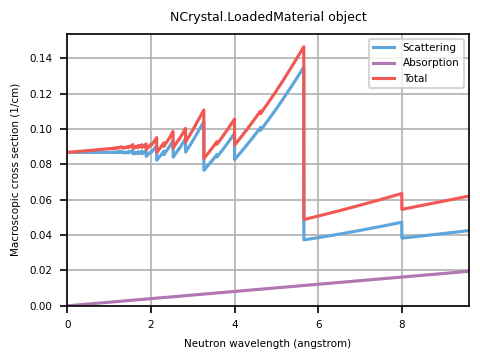

In [25]:
mat_siteoccu = c_siteoccu.load()
import pprint
pprint.pprint(mat_siteoccu.info.composition)
mat_siteoccu.plot(xsmode='macroscopic')

The takeaway for using NCMATComposer or CIFLoader for materials with non-unitary site occupancies:
* You can trust most results if you load and use the material in Python, but be aware of densities, composition, and per-atom cross sections.
* You can trust the results if using McStas (incl. McStasScript) because NCrystal provides the whole physics in terms of macroscopic cross sections.
* You can **NOT** use such materials in OpenMC or Geant4: they will likely fail already during initialisation when asked to prepare data with the element "Og" (Z=118).
* It is planned to extend the support, to make sure such materials can be used everywhere with no issues (see https://github.com/mctools/ncrystal/issues/68)

## Online databases
In addition to the Crystallography Open Database (COD) at https://www.crystallography.net/cod/, NCrystal currently has built-in support for one other database, namely the Materials Project at https://materialsproject.org/ which you can reference like "mpid::23231" (for the entry  https://www.materialsproject.org/materials/mp-23231). Unlike the very straight-forward usage of COD, there are a few things to be aware off when accessing the Materials Project:
* CIF data is generated on-the-fly on the Materials Project, so it might come in a variety of "settings" (e.g. low-precision vs. high-precision numbers, or primitive versus conventional cell). So to make sure you get a CIF file which is most appropriate for NCrystal, **do not download the CIF data from the website manually**. Instead, use the website to find the material ID (say, `23231`), and the use the string `mpid::23231` in place of a path to the CIF file in your NCrystal code.
* Access requires an API key. It is simple to get, just sign in to the materialsproject.org site (using e.g. your GitHub, google or facebook acount), and access your dashboard by clicking the small logo in the upper right corner. On the dashboard page you can see you API key, which is a (random looking) string of 32 characters. If you put that string into the environment variable named `MATERIALSPROJECT_USER_API_KEY`, then the access should work just as it does for COD. You can do that by putting an `export` statement in your `.bashrc`, or in whatever way is appropriate for your system. If all else fail, you can do it directly in Python:

In [26]:
import os
os.environ['MATERIALSPROJECT_USER_API_KEY'] = 'your32charkeygoeshere'

Finally, as done at the top of this notebook, note that you can avoid having NCrystal repeatedly download the same CIF files again and again from the online databases, if you set the following environment variable:

In [27]:
import os
os.environ['NCRYSTAL_ONLINEDB_CACHEDIR'] = './ncrystal_onlinedb_filecache'